## Part 1 - Common Analysis

Import all necessary libraries

In [1]:
from pyproj import Transformer, Geod
import geojson
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import shutil

Wildfire dataset taken from USGS

In [ ]:
input_gz_file = 'data_raw/USGS_Wildland_Fire_Combined_Dataset.json.gz'
FILENAME = 'data_raw/USGS_Wildland_Fire_Combined_Dataset.json'


with gzip.open(input_gz_file, 'rb') as f_in:
    with open(FILENAME, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"File decompressed and saved as {FILENAME}")

In [2]:
FILENAME = "/Users/dianechiang/Desktop/data_512/data_512_project/project/part_1/data_raw/USGS_Wildland_Fire_Combined_Dataset.json"

Odessa, TX is my assigned city

In [3]:
CITY_LOCATIONS = {
    'odessa': {'city': 'Odessa',
               'latlon' : [31.88, -102.35]}
}

Read in Wildfire data

In [4]:
print(f"Attempting to open '{FILENAME}'")
geojson_file = open(FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()

Attempting to open '/Users/dianechiang/Desktop/data_512/data_512_project/project/part_1/data_raw/USGS_Wildland_Fire_Combined_Dataset.json'
Using GeoJSON module to load sample file '/Users/dianechiang/Desktop/data_512/data_512_project/project/part_1/data_raw/USGS_Wildland_Fire_Combined_Dataset.json'


Filter Wildfire data to consist of fires that happened between 1961 - 2021

In [5]:
gj_feature_filtered = [feature for feature in gj_data['features'] if (feature['attributes']['Fire_Year'] >= 1961) & (feature['attributes']['Fire_Year'] <= 2024) ]

In [6]:
len(gj_feature_filtered)

118500

In [7]:
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()

    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        if len(coord) < 2: 
            break
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [8]:
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        if point[0] and point[1]:
            # calculate the distance
            d = geodcalc.inv(place[1],place[0],point[1],point[0])
            distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

In [9]:
gj_wf_distance = {}

In [10]:
place = CITY_LOCATIONS["odessa"]

for idx, wf_feature in enumerate(gj_feature_filtered):
    # print(idx)  # commented out for 
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']

    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        if len(wf_feature['geometry']['curveRings']) > 1:
            ring_data = wf_feature['geometry']['curveRings'][1]
        else:
            ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("HEY! No compatible geometry in this fire data!!!")
    
    # Compute using the average distance to all points on the perimeter
    avg_distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    gj_wf_distance[idx] = [wf_name, wf_year, wf_size, wf_type, avg_distance]

Avoid rerunning above code to get distance

In [11]:
len(gj_wf_distance)

118500

In [12]:
df_gj_wf_distance = pd.DataFrame.from_dict(gj_wf_distance, orient="index", columns=["fire_name", "fire_year", "fire_size", "fire_type", "avg_dis_from_odessa"])
df_gj_wf_distance.to_csv("data_intermediate/df_gj_wf_distance.csv")

In [13]:
# read from csv
# df_gj_wf_distance = pd.read_csv("/Users/dianechiang/Desktop/data_512/project/df_gj_wf_distance.csv")

In [14]:
df_gj_wf_distance.sort_values("avg_dis_from_odessa")

,fire_name,fire_year,fire_size,fire_type,avg_dis_from_odessa
85135,UNNAMED (1),2008,2615.745223,Unknown - Likely Prescribed Fire,4.667156
68492,BATES FIELD FIRE (1),2011,3186.865459,Wildfire,5.485374
82159,UNNAMED (1),1994,8266.558061,Unknown - Likely Prescribed Fire,6.769879
75577,S CURVE (1),2011,265.177481,Likely Wildfire,8.554308
68487,HICKMAN (2),2011,14828.276003,Wildfire,11.509564
...,...,...,...,...,...
58038,Tusikpak Lake (8),2018,14547.434185,Wildfire,3527.909642
68758,POKII RIDGE (1),2012,2027.904400,Wildfire,3563.477423
53977,Poovookpuk Mountain (4),2016,137.831379,Wildfire,3635.597190
53756,St Lawrence Island (2),2016,359.749823,Wildfire,3636.729655


In [15]:
def categorize_distance(distance):
    return ((distance - 1) // 50) + 1

In [16]:
df_gj_wf_distance['distance_category'] = df_gj_wf_distance['avg_dis_from_odessa'].apply(categorize_distance)

In [17]:
df_within_1800_from_odessa = df_gj_wf_distance[df_gj_wf_distance['avg_dis_from_odessa'] <= 1800]
df_within_1800_from_odessa

,fire_name,fire_year,fire_size,fire_type,avg_dis_from_odessa,distance_category
0,BIG ANTELOPE (5),1961,55249.740141,Wildfire,1240.244991,25.0
1,HARLOW (5),1961,43920.841077,Wildfire,1054.160858,22.0
2,RANCHERIA (5),1961,34233.698603,Wildfire,1134.805345,23.0
3,BOLLINGER RIDGE (5),1961,32866.053451,Wildfire,1147.934645,23.0
4,Ditch Creek (3),1961,27269.045936,Wildfire,1283.774013,26.0
...,...,...,...,...,...,...
118495,WEW CA Broadcast (3),2020,16.412148,Prescribed Fire,1383.834417,28.0
118496,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,2020,7.050837,Prescribed Fire,1194.731671,24.0
118497,2_PHMA_FIAT_Beulah_East_Bendire_NW_Malheur_Pri...,2020,9.342668,Prescribed Fire,1194.269316,24.0
118498,2_WUI_Chicken Rx (1),2020,0.996962,Prescribed Fire,701.305233,15.0


In [18]:
df_within_1800_from_odessa.sort_values('avg_dis_from_odessa')

,fire_name,fire_year,fire_size,fire_type,avg_dis_from_odessa,distance_category
85135,UNNAMED (1),2008,2615.745223,Unknown - Likely Prescribed Fire,4.667156,1.0
68492,BATES FIELD FIRE (1),2011,3186.865459,Wildfire,5.485374,1.0
82159,UNNAMED (1),1994,8266.558061,Unknown - Likely Prescribed Fire,6.769879,1.0
75577,S CURVE (1),2011,265.177481,Likely Wildfire,8.554308,1.0
68487,HICKMAN (2),2011,14828.276003,Wildfire,11.509564,1.0
...,...,...,...,...,...,...
101315,STEAM MILL (1),2013,12.366782,Prescribed Fire,1795.870959,36.0
108458,LYONBRIDGE (1),2018,18.673116,Prescribed Fire,1798.855287,36.0
102542,TEXAS FALLS FR 39 - TEXAS FALLS FR 39 RX FIRE ...,2014,22.340643,Prescribed Fire,1798.906802,36.0
96330,MAYO MEADOWS (1),2009,37.037041,Prescribed Fire,1799.925699,36.0


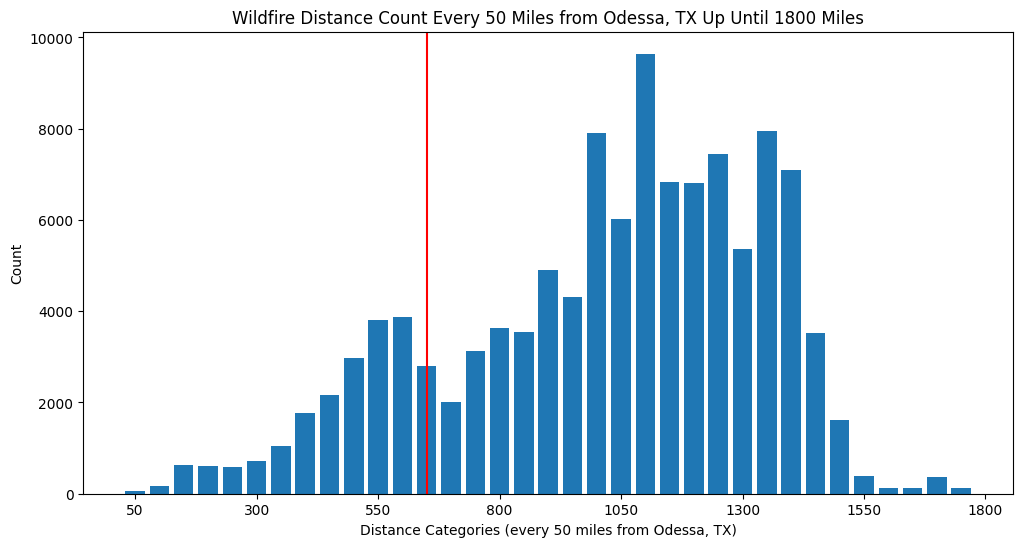

In [19]:
min_cat = int(df_within_1800_from_odessa['distance_category'].min())
max_cat = int(df_within_1800_from_odessa['distance_category'].max())
plt.figure(figsize=(12, 6))
plt.hist(df_within_1800_from_odessa['distance_category'], bins=range(min_cat, max_cat + 1), align='left', rwidth=0.8)
plt.axvline(x = 13, color = 'r', label = '650 miles from Odessa, TX')
plt.xlabel("Distance Categories (every 50 miles from Odessa, TX)")
plt.ylabel("Count")
plt.title("Wildfire Distance Count Every 50 Miles from Odessa, TX Up Until 1800 Miles")

xtick_positions = range(min_cat, max_cat + 1, 5)  # every 5th category (corresponding to 5*50 = 250 miles)
xtick_labels = [x * 50 for x in xtick_positions]

# Set x-ticks and their labels
plt.xticks(ticks=xtick_positions, labels=xtick_labels)

plt.show()

In [20]:
# Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
# 650 miles?
df_within_650_miles_away_from_odessa = df_gj_wf_distance[df_gj_wf_distance['avg_dis_from_odessa'] <= 650]
df_within_650_miles_away_from_odessa

,fire_name,fire_year,fire_size,fire_type,avg_dis_from_odessa,distance_category
23,No Fire Name Provided (8),1961,9870.377328,Wildfire,358.542587,8.0
24,No Fire Name Provided (2),1961,4995.989520,Wildfire,369.219161,8.0
25,No Fire Name Provided (2),1961,4995.932412,Wildfire,358.920911,8.0
26,No Fire Name Provided (2),1961,4995.885733,Wildfire,366.758097,8.0
27,No Fire Name Provided (2),1961,4995.651618,Wildfire,358.685926,8.0
...,...,...,...,...,...,...
118230,Orilla Verde Recreation Area - Salt Cedar Remo...,2017,4.440648,Prescribed Fire,362.940893,8.0
118237,1_MA_Hay Hollow North Fork (1),2018,5836.041286,Prescribed Fire,121.431462,3.0
118239,2_GUSG_TFO_West Rim Rx (1),2018,980.773974,Prescribed Fire,553.617641,12.0
118355,2_HL_Jackpot Burn 20 (1),2019,160.481181,Prescribed Fire,387.710668,8.0


In [21]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_sum_fire_size = df_within_650_miles_away_from_odessa.groupby("fire_year")['fire_size'].agg('sum').reset_index()
df_sum_fire_size.head()

,fire_year,fire_size
0,1961,53964.686
1,1962,36238.449
2,1963,11832.324
3,1964,27933.208
4,1965,3661.880


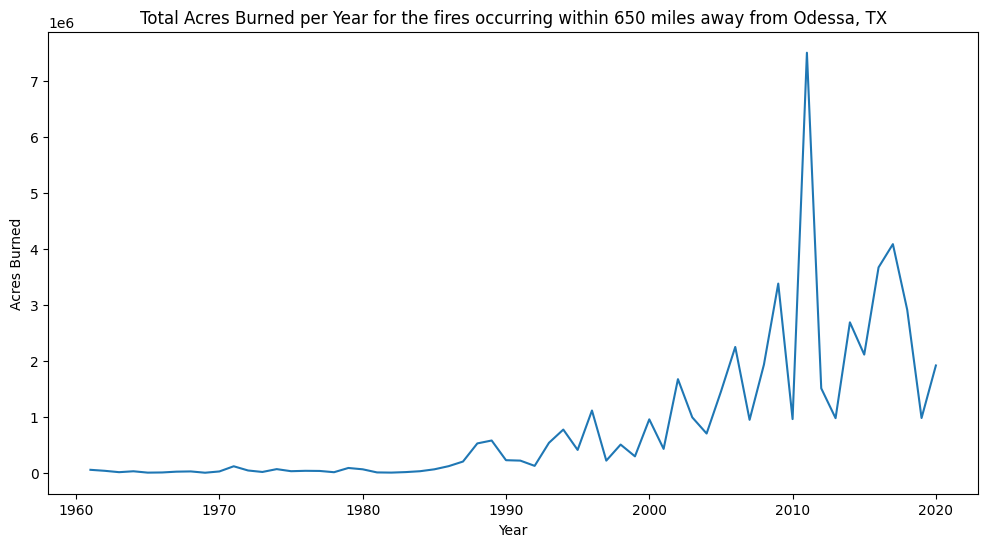

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df_sum_fire_size['fire_year'], df_sum_fire_size['fire_size'])
plt.ylabel("Acres Burned")
plt.xlabel("Year")
plt.title("Total Acres Burned per Year for the fires occurring within 650 miles away from Odessa, TX")
plt.show()

Calculate smoke estimate using the formula
$$S = k * (fire\_size\_in\_acres) * 0.0015625 * (\frac{1}{fire\_distance\_in\_miles})^2 * \alpha(1 + (Y - Y_0))$$
where $k$ has the unit $\mu g/m^3$ and $\alpha$ are both 5 for convenience and $Y_0$ is set to 1964 as the baseline year

In [23]:
df_within_650_miles_away_from_odessa_from_1964 = df_within_650_miles_away_from_odessa[df_within_650_miles_away_from_odessa['fire_year'] >= 1964]
df_within_650_miles_away_from_odessa_from_1964

,fire_name,fire_year,fire_size,fire_type,avg_dis_from_odessa,distance_category
1088,No Fire Name Provided (2),1964,4996.317,Wildfire,373.351,8.000
1089,No Fire Name Provided (2),1964,4995.726,Wildfire,362.369,8.000
1090,No Fire Name Provided (8),1964,4995.523,Wildfire,369.008,8.000
1091,No Fire Name Provided (4),1964,4995.490,Wildfire,365.752,8.000
1092,No Fire Name Provided (2),1964,4995.264,Wildfire,402.522,9.000
...,...,...,...,...,...,...
118230,Orilla Verde Recreation Area - Salt Cedar Remo...,2017,4.441,Prescribed Fire,362.941,8.000
118237,1_MA_Hay Hollow North Fork (1),2018,5836.041,Prescribed Fire,121.431,3.000
118239,2_GUSG_TFO_West Rim Rx (1),2018,980.774,Prescribed Fire,553.618,12.000
118355,2_HL_Jackpot Burn 20 (1),2019,160.481,Prescribed Fire,387.711,8.000


In [24]:
def calculate_smoke_density_estimate(fire_size, fire_distance, year):
    y_0 = 1964
    k = alpha = 5
    smoke = k * fire_size * 0.0015625 * (1 / fire_distance) * alpha * (1 + (year - y_0))
    return smoke

df_within_650_miles_away_from_odessa_from_1964['smoke_density_estimate'] = df_within_650_miles_away_from_odessa_from_1964.apply(
                                                                            lambda row: calculate_smoke_density_estimate(row['fire_size'], 
                                                                                                                         row['avg_dis_from_odessa'], 
                                                                                                                         row['fire_year']), axis = 1)


/var/folders/g6/2vpn8j992hg688vyx5njjx_r0000gn/T/ipykernel_28395/3657627845.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_within_650_miles_away_from_odessa_from_1964['smoke_density_estimate'] = df_within_650_miles_away_from_odessa_from_1964.apply(


In [25]:
df_within_650_miles_away_from_odessa_from_1964.to_csv("data_intermediate/df_within_650_miles_away_from_odessa_from_1964.csv")